In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorboard as tb

In [2]:
#experiment_id = "fL8jM1JXTbC5SnpQ90JWlQ"
#experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
#df = experiment.get_scalars()
#df.to_csv("results_logs.tsv", sep="\t", index=False)
#df

In [3]:
df = pd.read_csv("results_logs.tsv", sep="\t")
df.rename(columns={"run": "Method", "tag": "Feature", "value": "value"}, inplace=True)
df["Metric"] = df.Feature.str.split("_").str[0].str.upper()
df.Method.replace({"version_5": "PlantBert"}, inplace=True)
df = df[df.Method.isin(["DeepSEA", "DNABERT", "PlantBert"])]
df = df[df.Metric.isin(["AUPRC", "AUROC"])]
df["Feature class"] = df.Feature.str.split("_").str[1]
df

,Method,Feature,step,value,Metric,Feature class
0,DNABERT,auprc_DHS_Ath_flower_14_days,27080,0.634451,AUPRC,DHS
1,DNABERT,auprc_DHS_Ath_inflorescence_normal,27080,0.440137,AUPRC,DHS
2,DNABERT,auprc_DHS_Ath_leaf_normal,27080,0.465153,AUPRC,DHS
3,DNABERT,auprc_DHS_Ath_open_flower_normal,27080,0.505751,AUPRC,DHS
4,DNABERT,auprc_DHS_Ath_root_7_days,27080,0.574621,AUPRC,DHS
...,...,...,...,...,...,...
7016,PlantBert,auroc_TFBS_AT5G63790_Ath_seedling_normal,33450,0.894296,AUROC,TFBS
7017,PlantBert,auroc_TFBS_AT5G65310_Ath_seedling_ABA_treatmen...,33450,0.944521,AUROC,TFBS
7018,PlantBert,auroc_TFBS_AT5G65310_Ath_seedling_normal,33450,0.939791,AUROC,TFBS
7019,PlantBert,auroc_TFBS_AT5G67300_Ath_seedling_ABA_treatmen...,33450,0.936695,AUROC,TFBS


In [4]:
method_order = ["DeepSEA", "DNABERT", "PlantBert"]

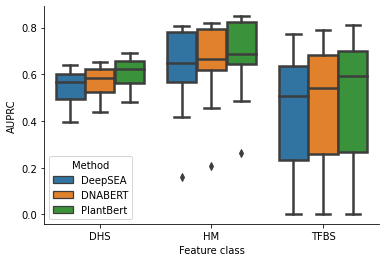

In [5]:
sns.boxplot(x="Feature class", y="value", hue="Method", data=df[df.Metric=="AUPRC"], hue_order=method_order, linewidth=2.5);
sns.despine()
plt.ylabel("AUPRC")
plt.savefig("auprc_boxplot.svg", bbox_inches='tight')

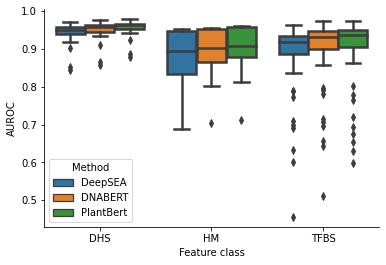

In [6]:
sns.boxplot(x="Feature class", y="value", hue="Method", data=df[df.Metric=="AUROC"], hue_order=method_order, linewidth=2.5);
sns.despine()
plt.ylabel("AUROC")
plt.savefig("auroc_boxplot.svg", bbox_inches='tight')

In [7]:
df2_auprc = df[df.Metric=="AUPRC"].pivot(index='Feature', columns='Method', values='value')
df2_auprc["Feature class"] = df2_auprc.index.str.split("_").str[1]
df2_auprc

Method,DNABERT,DeepSEA,PlantBert,Feature class
Feature,,,,
auprc_DHS_Ath_flower_14_days,0.634451,0.614921,0.677004,DHS
auprc_DHS_Ath_inflorescence_normal,0.440137,0.439895,0.492293,DHS
auprc_DHS_Ath_leaf_normal,0.465153,0.444190,0.504962,DHS
auprc_DHS_Ath_open_flower_normal,0.505751,0.484843,0.548213,DHS
auprc_DHS_Ath_root_7_days,0.574621,0.555127,0.609742,DHS
...,...,...,...,...
auprc_TFBS_AT5G63790_Ath_seedling_normal,0.245625,0.212799,0.262692,TFBS
auprc_TFBS_AT5G65310_Ath_seedling_ABA_treatment_for_4h,0.662923,0.606286,0.670793,TFBS
auprc_TFBS_AT5G65310_Ath_seedling_normal,0.670756,0.610986,0.672918,TFBS


In [30]:
def scatter_plot(df, metric, methods):
    df2 = df[df.Metric==metric].pivot(index='Feature', columns='Method', values='value')
    df2["Feature class"] = df2.index.str.split("_").str[1]
    sns.scatterplot(data=df2, x=methods[0], y=methods[1], hue="Feature class", palette="Set2", linewidth=0)
    vmin, vmax = df2[methods].min().min() - 1/100, df2[methods].max().max() + 1/100
    plt.xlim([vmin, vmax])
    plt.ylim([vmin, vmax])
    sns.despine()
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.title(metric)
    plt.gca().set_aspect('equal', 'box')
    plt.savefig(f"scatterplot_{metric}_{methods}.svg", bbox_inches='tight')

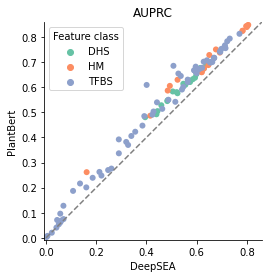

In [28]:
scatter_plot(df, "AUPRC", ["DeepSEA", "PlantBert"])

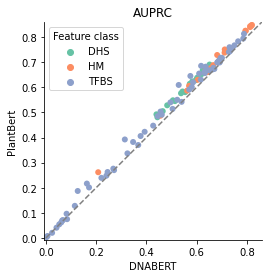

In [29]:
scatter_plot(df, "AUPRC", ["DNABERT", "PlantBert"])

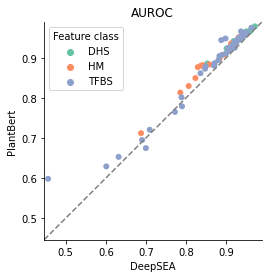

In [31]:
scatter_plot(df, "AUROC", ["DeepSEA", "PlantBert"])

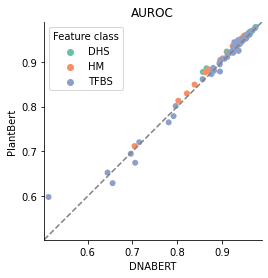

In [32]:
scatter_plot(df, "AUROC", ["DNABERT", "PlantBert"])